In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats

def plot_weights(theta, feature_names=None, output_names=None):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(theta, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

    plt.title("Theta (Weights)")
    plt.xlabel("Output Dimension")
    plt.ylabel("Feature Index")

    if feature_names is not None:
        plt.yticks(ticks=np.arange(len(feature_names)) + 0.5, labels=feature_names, rotation=0)
    if output_names is not None:
        plt.xticks(ticks=np.arange(len(output_names)) + 0.5, labels=output_names, rotation=0)

    plt.tight_layout()
    plt.show()


Below is an implementation of multiple linear regression (MLR). W-values won't work with a straightforward implementation of univariate linear regression since $\beta=0$ in this case.

We fit an MLR on the ENB dataset, using gradient descent to find the best weights. It compares no regularization, L1 regularization, and w-values. 


Training: PLAIN


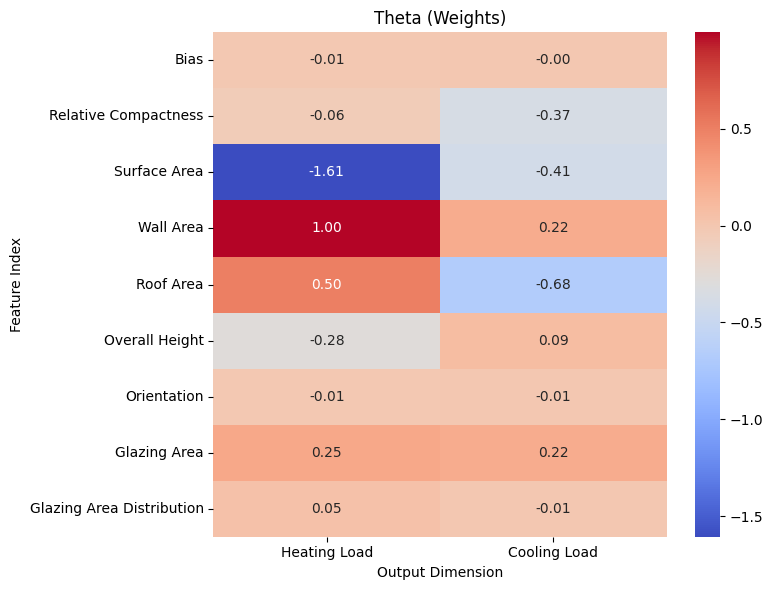


Training: REGULARIZED


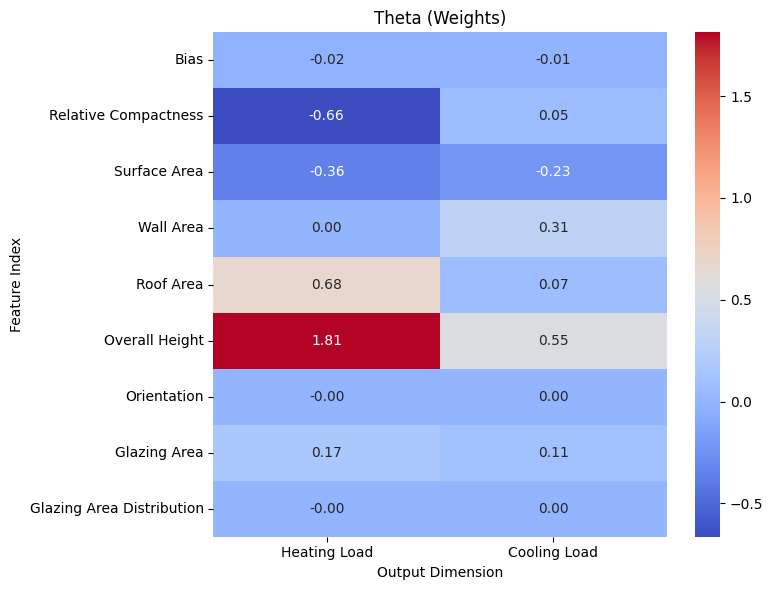


Training: MASKED


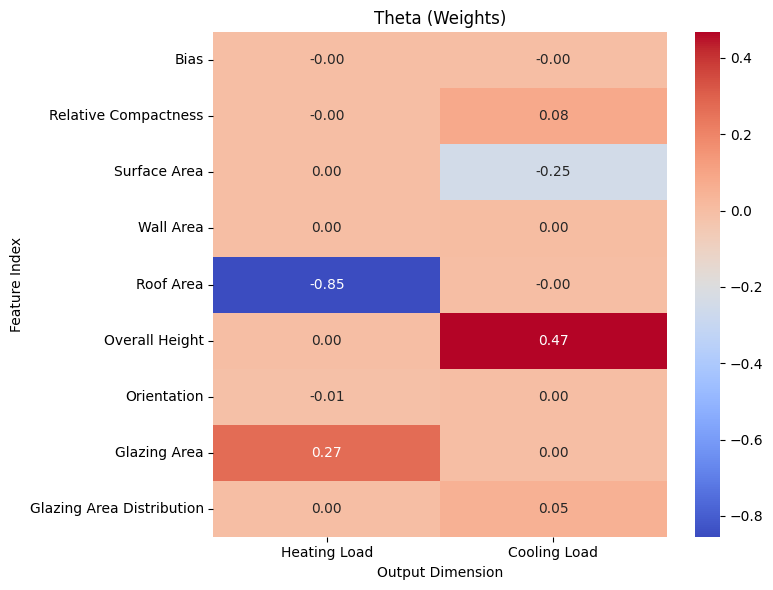

Plain Test MSE per output: [0.19037158 0.16862676]
Regularized Test MSE per output: [0.16252624 0.15169566]
Masked Test MSE per output: [0.20648999 0.3293767 ]


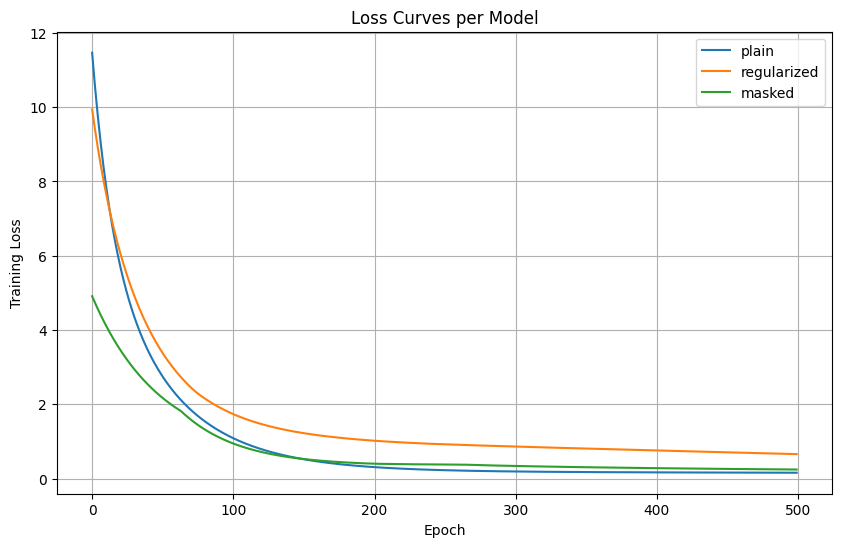

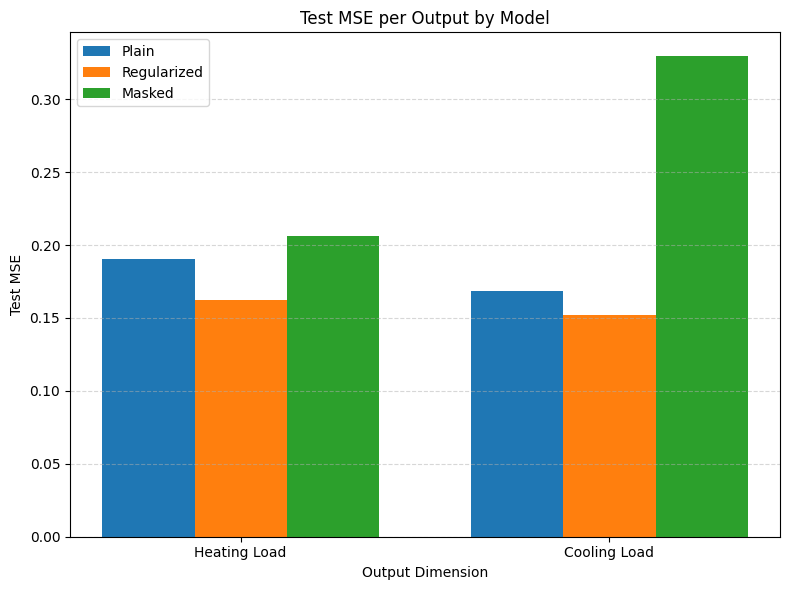

In [3]:


# 1. Load ENB dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

X = df.iloc[:, :8].values
Y = df.iloc[:, 8:10].values  # Heating & Cooling Load

# 2. Normalize
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

# 3. Add bias term
X = np.hstack([np.ones((X.shape[0], 1)), X])

# 4. Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 5. Settings
alpha = 0.01
epochs = 500
n_samples, n_features = X_train.shape
n_outputs = Y_train.shape[1]
lambda_ = 1e-1
thresh = 1.4
a, b = 0.5, 0.5 * (n_outputs - 1)

feature_names = ["Relative Compactness", "Surface Area", "Wall Area", "Roof Area", 
                 "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution"]

feature_names = ["Bias"] + feature_names  # Add bias term

output_names = ["Heating Load", "Cooling Load"]

def train_model(mode="plain"):
    theta = np.random.randn(n_features, n_outputs)
    losses = []

    for epoch in range(epochs):
        if mode == "masked":
            norm_theta = np.linalg.norm(theta, axis=1, keepdims=True)
            normed_theta = (theta / norm_theta) ** 2
            cdf = stats.beta.cdf(normed_theta, a, b)
            sf = np.clip(1 - cdf, 1e-8, 1 - 1e-8)
            w_val = -np.log(sf)
            mask = w_val >= thresh
            theta = mask * theta  # Apply masking before update

        Y_pred = X_train @ theta
        error = Y_pred - Y_train
        mse_loss = (1 / (2 * n_samples)) * np.sum(error ** 2)

        # Regularization
        if mode == "regularized":
            loss = mse_loss + lambda_ * np.sum(np.abs(theta[1:, :]))
        else:
            loss = mse_loss

        losses.append(loss)

        # Gradients
        grad_mse = (1 / n_samples) * (X_train.T @ error)
        if mode == "regularized":
            grad_reg = lambda_ * np.sign(theta)
            grad_reg[0, :] = 0  # no bias penalty
            grad_total = grad_mse + grad_reg
        else:
            grad_total = grad_mse

        theta -= alpha * grad_total

    return theta, losses

# 6. Train all models
models = {}
for mode in ["plain", "regularized", "masked"]:
    print(f"\nTraining: {mode.upper()}")
    theta, losses = train_model(mode)
    plot_weights(theta, feature_names, output_names)
    models[mode] = {"theta": theta, "losses": losses}

# 7. Evaluate
for mode, data in models.items():
    theta = data["theta"]
    Y_pred = X_test @ theta
    mse = np.mean((Y_pred - Y_test) ** 2, axis=0)
    print(f"{mode.capitalize()} Test MSE per output: {mse}")

# 8. Plot loss curves
plt.figure(figsize=(10, 6))
for mode, data in models.items():
    plt.plot(data["losses"], label=mode)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curves per Model")
plt.legend()
plt.grid(True)
plt.show()

# 9. Bar chart comparison of test MSEs
output_labels = ["Heating Load", "Cooling Load"]
model_names = list(models.keys())
mse_matrix = np.array([np.mean((X_test @ models[m]["theta"] - Y_test) ** 2, axis=0) for m in model_names])

x = np.arange(len(output_labels))  # Heating / Cooling
width = 0.25

plt.figure(figsize=(8, 6))
for i, model in enumerate(model_names):
    plt.bar(x + i * width, mse_matrix[i], width, label=model.capitalize())

plt.xlabel("Output Dimension")
plt.ylabel("Test MSE")
plt.title("Test MSE per Output by Model")
plt.xticks(x + width, output_labels)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Here we are creating synthetic data - using a synthetic weight matrix - and trying to learn these weights. Depending on the value of W_true, we can have a sparse or non-sparse matrix, and try to learn it. We compare no regularization, L1, L2, and WV. The squared error distance between the true weights and learned weights is also given. 

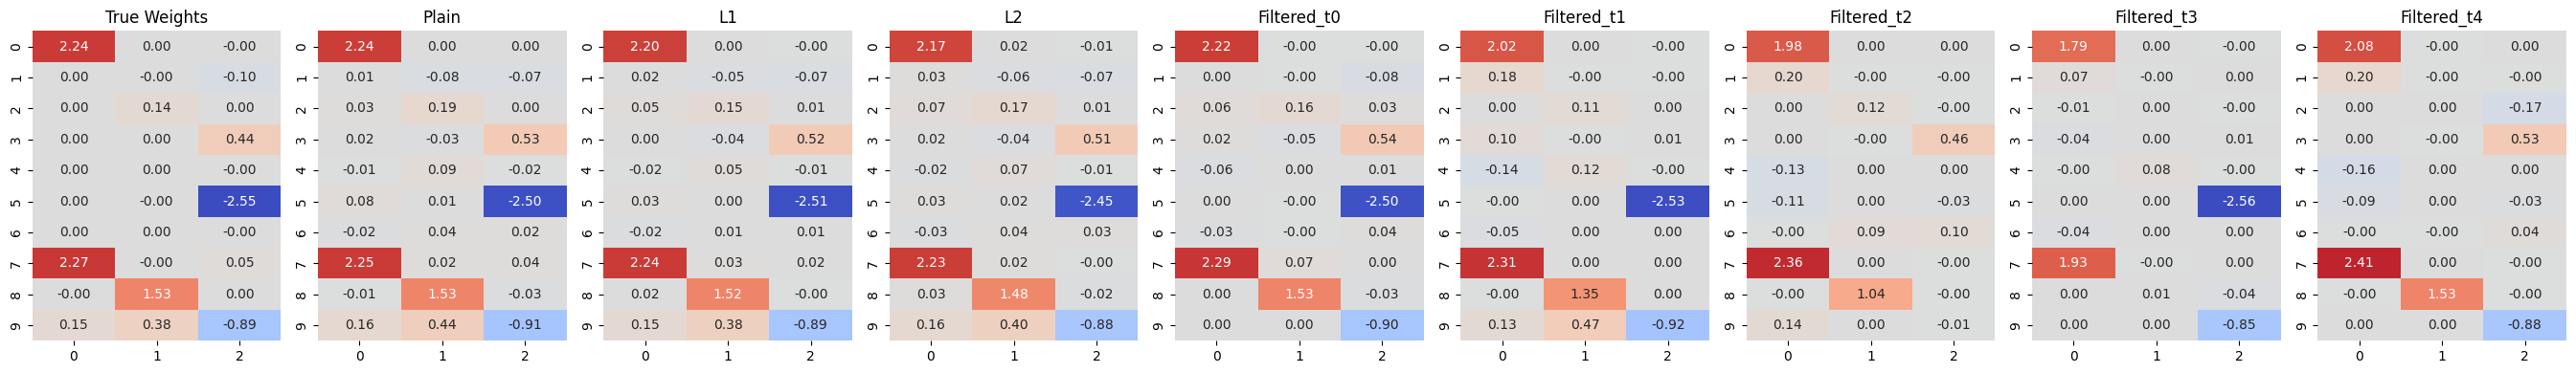


L2 Distance to True Weights (excluding bias):
Plain       : 0.2170
L1          : 0.1582
L2          : 0.2274
Filtered_t0 : 0.4465
Filtered_t1 : 0.6149
Filtered_t2 : 2.7779
Filtered_t3 : 1.7409
Filtered_t4 : 2.5972


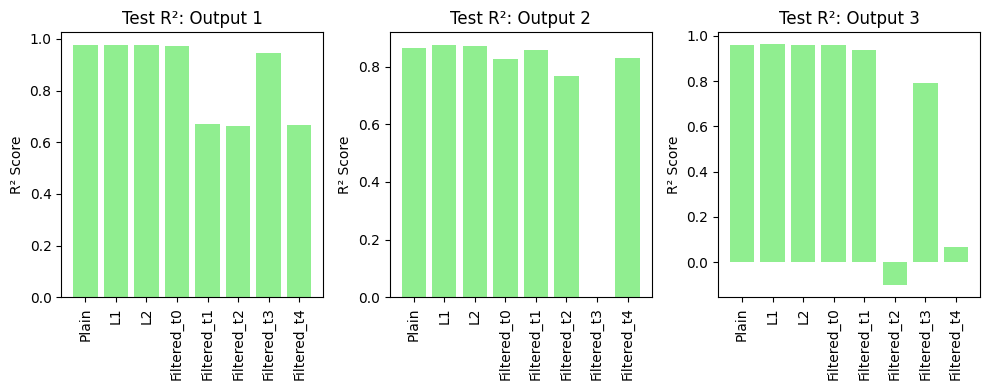

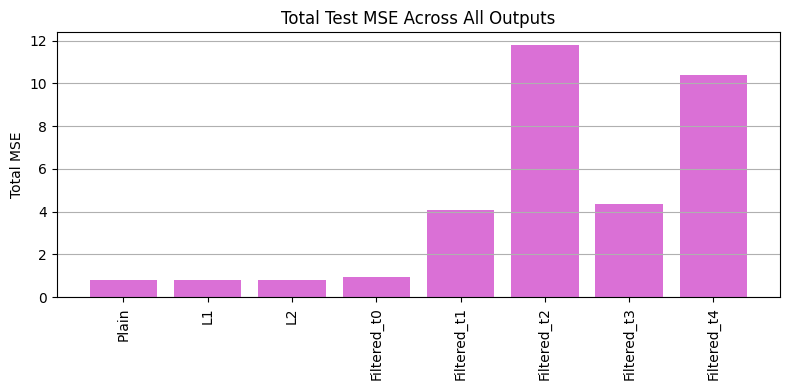

In [35]:
# ---------------------------
# 1. Parameters and True Weights
# ---------------------------
n_samples = 500
n_features = 10
n_outputs = 3
noise_std = 0.5 
# Increase std to make non-WV perform as poorly as WV

np.random.seed(0)
def generate_sparse_weights(n_features, n_outputs, sparsity=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    W = np.random.randn(n_features, n_outputs)
    mask = np.random.rand(n_features, n_outputs) > sparsity
    W *= mask
    return W

# Pick sparse vs non-sparse weights for truth
# W_true = np.random.randn(n_features + 1, n_outputs)  # true weights incl. bias
W_true = generate_sparse_weights(n_features + 1, n_outputs)

# ---------------------------
# 2. Synthetic Data Generation
# ---------------------------
X = np.random.randn(n_samples, n_features)
X = np.hstack([np.ones((n_samples, 1)), X])
Y = X @ W_true + np.random.randn(n_samples, n_outputs) * noise_std

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# x_scaler = StandardScaler()
# y_scaler = StandardScaler()
# X_train[:, 1:] = x_scaler.fit_transform(X_train[:, 1:])
# X_test[:, 1:] = x_scaler.transform(X_test[:, 1:])
# Y_train = y_scaler.fit_transform(Y_train)
# Y_test = y_scaler.transform(Y_test)

# ---------------------------
# 3. Model Trainer Function
# ---------------------------
def train_model(X, Y, reg_type=None, lambda_=0.01, use_filter=False, thresh=1.4, epochs=1000, alpha=0.01):
    theta = np.random.randn(X.shape[1], Y.shape[1])
    a, b = 0.5, 0.5 * (Y.shape[1] - 1)

    for epoch in range(epochs):
        if use_filter:
            norm_theta = np.linalg.norm(theta, axis=1, keepdims=True)
            normed_theta = (theta / norm_theta)**2
            cdf = stats.beta.cdf(normed_theta, a, b)
            sf = np.clip(1 - cdf, 1e-8, 1 - 1e-8)
            w_val = -np.log(sf)
            mask = w_val >= thresh
            theta = theta * mask

        Y_pred = X @ theta
        error = Y_pred - Y
        grad = (1 / len(X)) * (X.T @ error)

        if reg_type == 'l1':
            grad += lambda_ * np.sign(theta)
            grad[0, :] -= lambda_ * np.sign(theta[0, :])
        elif reg_type == 'l2':
            grad += 2 * lambda_ * theta
            grad[0, :] -= 2 * lambda_ * theta[0, :]

        theta -= alpha * grad
    return theta

# ---------------------------
# 4. Train Models
# ---------------------------
models = {
    "Plain": train_model(X_train, Y_train, epochs=500),
    "L1": train_model(X_train, Y_train, reg_type='l1', lambda_=0.01, epochs=500),
    "L2": train_model(X_train, Y_train, reg_type='l2', lambda_=0.01, epochs=500),
    "Filtered_t0": train_model(X_train, Y_train, use_filter=True, thresh=0.01, epochs=500),
    "Filtered_t1": train_model(X_train, Y_train, use_filter=True, thresh=0.10, epochs=500),
    "Filtered_t2": train_model(X_train, Y_train, use_filter=True, thresh=0.35, epochs=500),
    "Filtered_t3": train_model(X_train, Y_train, use_filter=True, thresh=0.7, epochs=500),
    "Filtered_t4": train_model(X_train, Y_train, use_filter=True, thresh=1.4, epochs=500),
    # "Filtered_t5": train_model(X_train, Y_train, use_filter=True, thresh=2.3, epochs=500),
    # "Filtered_t6": train_model(X_train, Y_train, use_filter=True, thresh=3, epochs=500),

}

# ---------------------------
# 5. Visualize Weights Comparison
# ---------------------------
def plot_weight_heatmaps(true_weights, models):
    all_weights = [true_weights[1:]] + [theta[1:] for theta in models.values()]
    vmin = min(w.min() for w in all_weights)
    vmax = max(w.max() for w in all_weights)
    vlim = max(abs(vmin), abs(vmax))
    vmin, vmax = -vlim, vlim

    fig, axs = plt.subplots(1, len(models) + 1, figsize=(3 * (len(models) + 1), 4))

    sns.heatmap(true_weights[1:], annot=True, cmap='coolwarm',
                ax=axs[0], fmt=".2f", vmin=vmin, vmax=vmax, cbar=False)
    axs[0].set_title("True Weights")

    for i, (name, theta) in enumerate(models.items(), 1):
        sns.heatmap(theta[1:], annot=True, cmap='coolwarm',
                    ax=axs[i], fmt=".2f", vmin=vmin, vmax=vmax, cbar=False)
        axs[i].set_title(f"{name}")

    plt.tight_layout()
    plt.show()

plot_weight_heatmaps(W_true, models)

# ---------------------------
# 6. Quantitative Comparison
# ---------------------------
def compare_weight_errors(true_w, model_dict):
    print("\nL2 Distance to True Weights (excluding bias):")
    for name, theta in model_dict.items():
        err = np.linalg.norm(true_w[1:] - theta[1:])
        print(f"{name:<12}: {err:.4f}")

compare_weight_errors(W_true, models)

# ---------------------------
# 7. Test Loss and Accuracy Plots
# ---------------------------
test_mse = {}
test_r2 = {}

for name, theta in models.items():
    Y_pred = X_test @ theta
    mse = np.mean((Y_pred - Y_test)**2, axis=0)
    test_mse[name] = mse

    var = np.var(Y_test, axis=0)
    r2 = 1 - mse / var
    test_r2[name] = r2

# # Plot test MSE
# plt.figure(figsize=(10, 4))
# for i, out in enumerate(["Output 1", "Output 2", "Output 3"]):
#     plt.subplot(1, 3, i+1)
#     plt.bar(test_mse.keys(), [test_mse[name][i] for name in models], color='skyblue')
#     plt.xticks(rotation=90)
#     plt.title(f"Test MSE: {out}")
#     plt.ylabel("MSE")
# plt.tight_layout()
# plt.show()

# Plot test R2 (accuracy)
plt.figure(figsize=(10, 4))
for i, out in enumerate(["Output 1", "Output 2", "Output 3"]):
    plt.subplot(1, 3, i+1)
    plt.bar(test_r2.keys(), [test_r2[name][i] for name in models], color='lightgreen')
    plt.xticks(rotation=90)
    plt.title(f"Test R²: {out}")
    plt.ylabel("R² Score")
plt.tight_layout()
plt.show()

# ---------------------------
# 7b. Total Test MSE per Model (Aggregate)
# ---------------------------
total_test_mse = {name: np.sum(mse) for name, mse in test_mse.items()}

# Plot total test MSE
plt.figure(figsize=(8, 4))
plt.bar(total_test_mse.keys(), total_test_mse.values(), color='orchid')
plt.xticks(rotation=90)
plt.title("Total Test MSE Across All Outputs")
plt.ylabel("Total MSE")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
